# AI model for predicting the electricity prices

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

from LSTMmodel import *
%load_ext autoreload
%autoreload 2

In [2]:
# moving to GPU if available (Metal)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: mps


## Loading the data

In [3]:
# path to the CSV file
path = '../../data/fulldata.csv'

data = pd.read_csv(path)

display(data.head())
print(data.shape)

,SpotPriceDKK,from,to,temp_Aabenraa,temp_Aalborg,temp_Aarhus,temp_Assens,temp_Billund,temp_Brønderslev,temp_Esbjerg,...,wind_speed_Syddjurs,wind_speed_Sønderborg,wind_speed_Thisted,wind_speed_Tønder,wind_speed_Varde,wind_speed_Vejen,wind_speed_Vejle,wind_speed_Vesthimmerlands,wind_speed_Viborg,wind_speed_Ærø
0,291.329987,2024-10-20 05:00:00+00:00,2024-10-20 06:00:00+00:00,12.3,11.9,11.9,12.2,12.4,11.7,12.4,...,3.0,3.2,6.4,3.8,4.7,3.7,3.5,5.1,4.2,3.9
1,240.389999,2024-10-20 04:00:00+00:00,2024-10-20 05:00:00+00:00,12.4,11.7,11.9,12.4,12.4,11.4,12.4,...,3.1,3.9,5.9,4.0,5.4,3.5,3.3,4.6,4.0,4.1
2,241.880005,2024-10-20 03:00:00+00:00,2024-10-20 04:00:00+00:00,12.5,11.4,11.9,12.5,12.3,11.3,12.4,...,3.2,3.3,5.8,4.2,5.6,3.4,3.2,4.7,4.2,4.5
3,444.450012,2024-10-20 02:00:00+00:00,2024-10-20 03:00:00+00:00,12.4,11.4,11.6,12.5,12.0,11.5,12.4,...,2.5,3.3,5.7,4.2,5.2,3.4,3.2,4.8,4.0,4.4
4,417.000000,2024-10-20 01:00:00+00:00,2024-10-20 02:00:00+00:00,12.4,11.8,11.2,12.4,11.7,12.1,12.3,...,2.1,3.6,5.5,4.0,5.0,3.5,3.2,3.7,3.2,3.7


(120991, 471)


## Data preprocessing

In [4]:
data['from'] = pd.to_datetime(data['from'])

# drop to column
data = data.drop(columns=['to'])

# get old prices 
lag_hours = [0, 
            -1, -2, -3, -4, -5, -6, -24, -48, -72, -96, -120, -144, -168
             ]
for lag in lag_hours:
    data[f'price_lag_{lag}'] = data['SpotPriceDKK'].shift(lag)

# offset price by 1 day
data['SpotPriceDKK'] = data['SpotPriceDKK'].shift(24)
# drop the first 24 rows
data = data.dropna()

# offset the from date by 1 day to match the price
data['from'] = data['from'] + pd.DateOffset(days=1)

# cyclical encoding for hour, day, and month
data['hour'] = data['from'].dt.hour
data['day'] = data['from'].dt.dayofweek
data['month'] = data['from'].dt.month

cyclical_encoding(data,'hour',24)
cyclical_encoding(data,'day',7)
cyclical_encoding(data,'month',12)

# sort data to be ascending
data = data.sort_values('from')

display(data.head())
print(data.shape)

,SpotPriceDKK,from,temp_Aabenraa,temp_Aalborg,temp_Aarhus,temp_Assens,temp_Billund,temp_Brønderslev,temp_Esbjerg,temp_Faaborg-Midtfyn,...,price_lag_-168,hour,day,month,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
120822,242.839996,2011-01-08 23:00:00+00:00,0.6,-0.1,-0.6,0.7,0.0,-0.3,0.4,0.8,...,2.38,23,5,1,-0.258819,0.965926,-0.974928,-0.222521,0.5,0.866025
120821,160.899994,2011-01-09 00:00:00+00:00,0.7,-0.1,-0.6,0.7,0.1,-0.2,0.5,0.9,...,13.64,0,6,1,0.000000,1.000000,-0.781831,0.623490,0.5,0.866025
120820,117.620003,2011-01-09 01:00:00+00:00,1.0,0.0,-0.5,0.7,0.1,-0.2,0.6,1.1,...,-11.40,1,6,1,0.258819,0.965926,-0.781831,0.623490,0.5,0.866025
120819,78.959999,2011-01-09 02:00:00+00:00,1.4,0.0,-0.3,0.8,0.2,-0.3,0.8,1.2,...,-11.40,2,6,1,0.500000,0.866025,-0.781831,0.623490,0.5,0.866025
120818,77.470001,2011-01-09 03:00:00+00:00,1.8,0.1,0.1,1.0,0.5,-0.5,1.2,1.3,...,2.53,3,6,1,0.707107,0.707107,-0.781831,0.623490,0.5,0.866025


(120799, 493)


In [5]:
# extract column names
cols = data.columns.tolist()

# select features and target variable
all_features = cols[2:]
target = cols[:1]

print(f'Count of features before interaction terms: {len(all_features)}')
print(f'Target variable: {target}')

Count of features before interaction terms: 491
Target variable: ['SpotPriceDKK']


In [ ]:
# training data: until July 2023
train_data = data[data['from'] < '2023-08-01']
# train_data = data[(data['from'] >= '2016-04-01') & (data['from'] < '2023-08-01')]

# validation data: July 2023 to December 2023
val_data = data[(data['from'] >= '2023-08-01') & (data['from'] < '2024-08-01')]

# Test data: 2024 and beyond
test_data = data[data['from'] >= '2024-08-01']

X_train = train_data[all_features].values
X_val = val_data[all_features].values
X_test = test_data[all_features].values

In [7]:
# initialize the scaler
scaler = StandardScaler()

# fit the scaler on the training features and transform
train_features_scaled = scaler.fit_transform(X_train)

# transform the validation and test features using the same scaler
val_features_scaled = scaler.transform(X_val)
test_features_scaled = scaler.transform(X_test)


In [8]:
# extract target values
train_targets = train_data[target].values
val_targets = val_data[target].values
test_targets = test_data[target].values

## Model building

In [9]:
# set seed for reproducibility
torch.manual_seed(1998)
np.random.seed(1998)

# hyperparameters
seq_length = 24  # Use past 24 hours to form a sequence
batch_size = 256
input_dim = train_features_scaled.shape[1]
hidden_dim = 128
layer_dim = 2
output_dim = 1
learning_rate = 0.001

# regularization parameter
lambda_l1 = 1.5 # Adjust based on desired regularization strength
lambda_l2 = 1e-4 # Adjust based on desired regularization strength

In [10]:
# create datasets
train_dataset = dataset(train_features_scaled, train_targets, seq_length)
val_dataset = dataset(val_features_scaled, val_targets, seq_length)
test_dataset = dataset(test_features_scaled, test_targets, seq_length)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# initialize the model
model = LSTMmodel(input_dim, hidden_dim, layer_dim, output_dim).to(device)

# loss evaluation function
criterion = nn.MSELoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Model training

In [11]:
# training the model
num_epochs = 150
patience = 25  # for early stopping
best_loss = np.inf
counter = 0

# initialize lists to store loss values
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        # forward pass
        outputs = model(X_batch)

        mse_loss = criterion(outputs.squeeze(), y_batch.squeeze())

        # L1 regularization
        l1_loss = l1_regularization(model, lambda_l1)
        l2_loss = l2_regularization(model, lambda_l2)

        # calc total loss
        loss = mse_loss + l1_loss + l2_loss

        # backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    # average training loss
    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)

    # validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            mse_loss = criterion(outputs.squeeze(), y_batch.squeeze())
            l1_loss = l1_regularization(model, lambda_l1)
            l2_loss = l2_regularization(model, lambda_l2)
            loss = mse_loss + l1_loss + l2_loss
            val_losses.append(loss.item())

    avg_val_loss = np.mean(val_losses)
    validation_losses.append(avg_val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    n_epoch = epoch+1
    # torch.save(model.state_dict(), 'output/last_model.pth')
    
    # early stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        counter = 0
        # save the best model
        torch.save(model.state_dict(), 'output/best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break



Epoch [1/150], Training Loss: 691125.2783, Validation Loss: 328842.3114
Epoch [2/150], Training Loss: 653284.3130, Validation Loss: 299345.7781
Epoch [3/150], Training Loss: 624801.6594, Validation Loss: 273263.7460
Epoch [4/150], Training Loss: 599384.8149, Validation Loss: 249948.1079
Epoch [5/150], Training Loss: 576536.7037, Validation Loss: 229042.9161
Epoch [6/150], Training Loss: 556083.2512, Validation Loss: 210402.8213
Epoch [7/150], Training Loss: 537824.5021, Validation Loss: 193810.5703
Epoch [8/150], Training Loss: 521480.8545, Validation Loss: 179068.4633
Epoch [9/150], Training Loss: 506977.5358, Validation Loss: 166078.5646
Epoch [10/150], Training Loss: 494202.3098, Validation Loss: 154711.0408
Epoch [11/150], Training Loss: 483026.1729, Validation Loss: 144894.8439
Epoch [12/150], Training Loss: 473321.7037, Validation Loss: 136434.8349
Epoch [13/150], Training Loss: 464960.3809, Validation Loss: 129272.3727
Epoch [14/150], Training Loss: 457892.7410, Validation Loss:

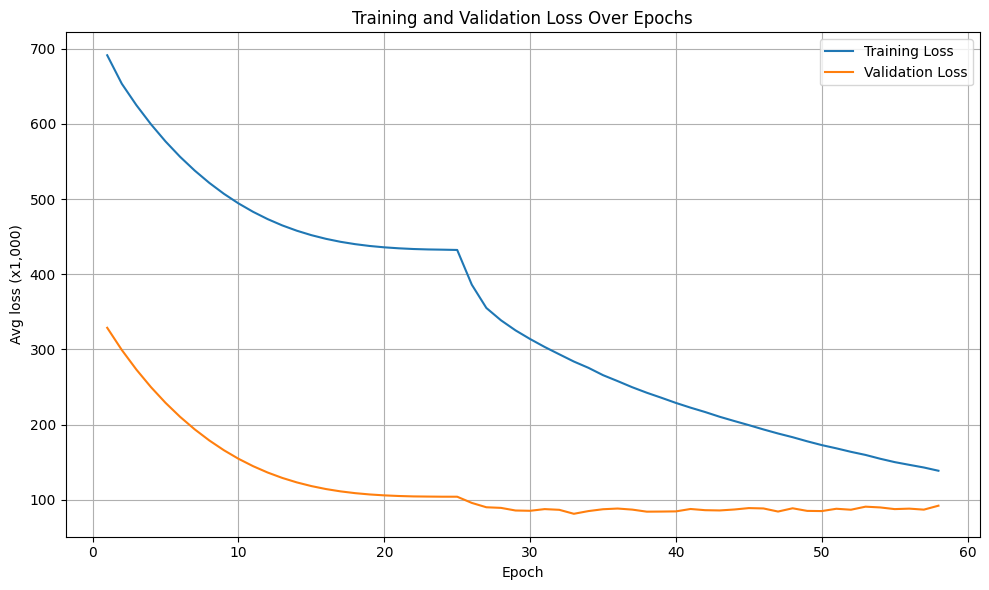

In [12]:
train_losses = np.array(training_losses)/1000
val_losses = np.array(validation_losses)/1000

# Plotting the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epoch + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epoch + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Avg loss (x1,000)')
# plt.yscale('log')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Model evaluation and plotting

In [13]:
# load the best model
model.load_state_dict(torch.load('output/best_model.pth'))

model.eval()
with torch.no_grad():
    predictions = []
    actuals = []
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        predictions.extend(outputs.squeeze().tolist())
        #
        
        actuals.extend(y_batch.tolist())

rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Performance on test data (2024):\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}\nR^2 Score: {r2:.4f}')


Performance on test data (2024):
RMSE: 324.4327
MAE: 257.8787
R^2 Score: 0.1795


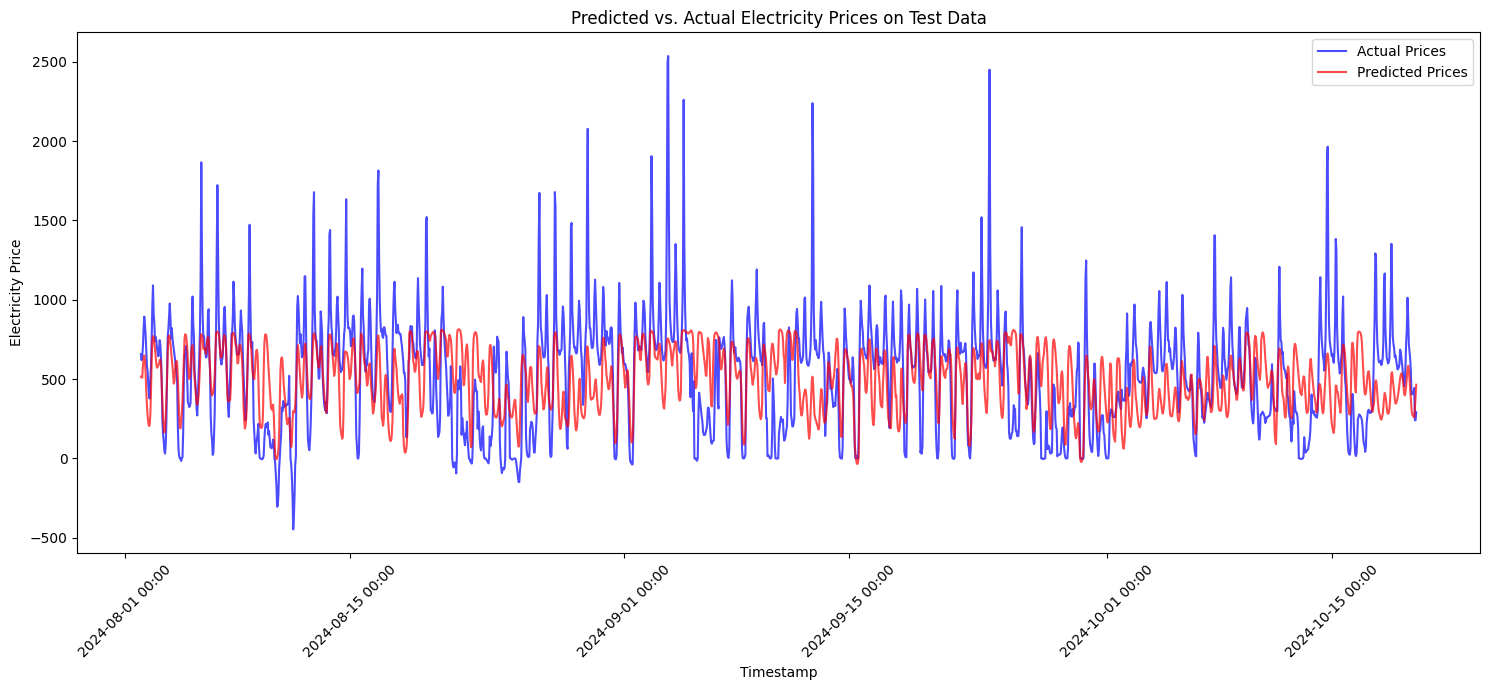

In [14]:
# convert 'predictions' and 'actuals' to numpy arrays
predictions = np.array(predictions)
actuals = np.array(actuals)

# extract 'from' timestamps from test_data, adjusted for seq_length
# since the dataset uses sequences, the first 'seq_length' targets are not included in 'actuals' and 'predictions'
test_timestamps = test_data['from'].values[seq_length:]

# ensure lengths match
min_length = min(len(test_timestamps), len(actuals), len(predictions))
test_timestamps = test_timestamps[:min_length]
actuals = actuals[:min_length]
predictions = predictions[:min_length]

# create the plot
plt.figure(figsize=(15, 7))
plt.plot(test_timestamps, actuals, label='Actual Prices', color='blue', alpha=0.7)
plt.plot(test_timestamps, predictions, label='Predicted Prices', color='red', alpha=0.7)
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Electricity Price')
plt.title('Predicted vs. Actual Electricity Prices on Test Data')

# format x-axis with date labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('output/lstm_predicted_vs_actual_prices2024.png')

plt.show()

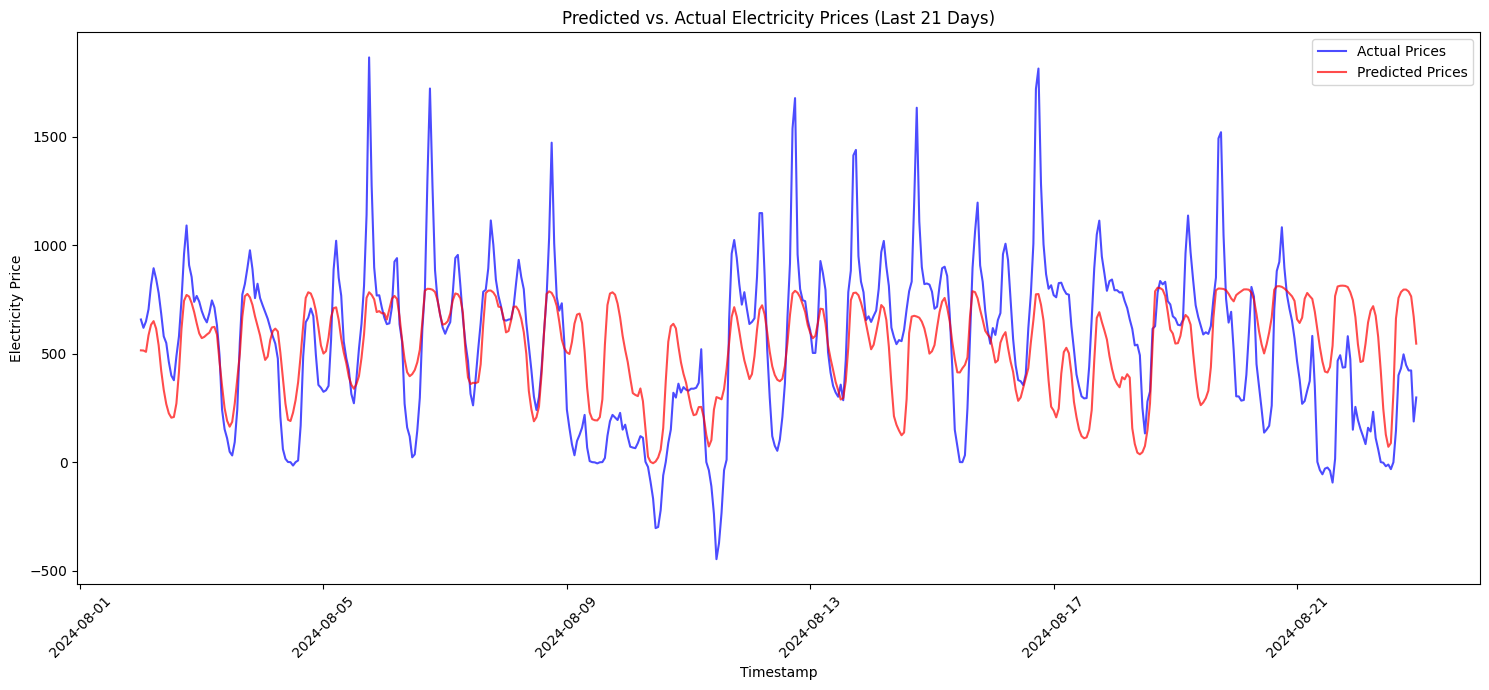

In [15]:
# plot the first 500 data points
datapoints = 24*21
plt.figure(figsize=(15, 7))
plt.plot(test_timestamps[:datapoints], actuals[:datapoints], label='Actual Prices', color='blue', alpha=0.7)
plt.plot(test_timestamps[:datapoints], predictions[:datapoints], label='Predicted Prices', color='red', alpha=0.7)
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Electricity Price')
plt.title(f'Predicted vs. Actual Electricity Prices (Last {datapoints//24} Days)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig(f'output/lstm_predicted_vs_actual_prices_last{datapoints//24}days.png')
plt.show()


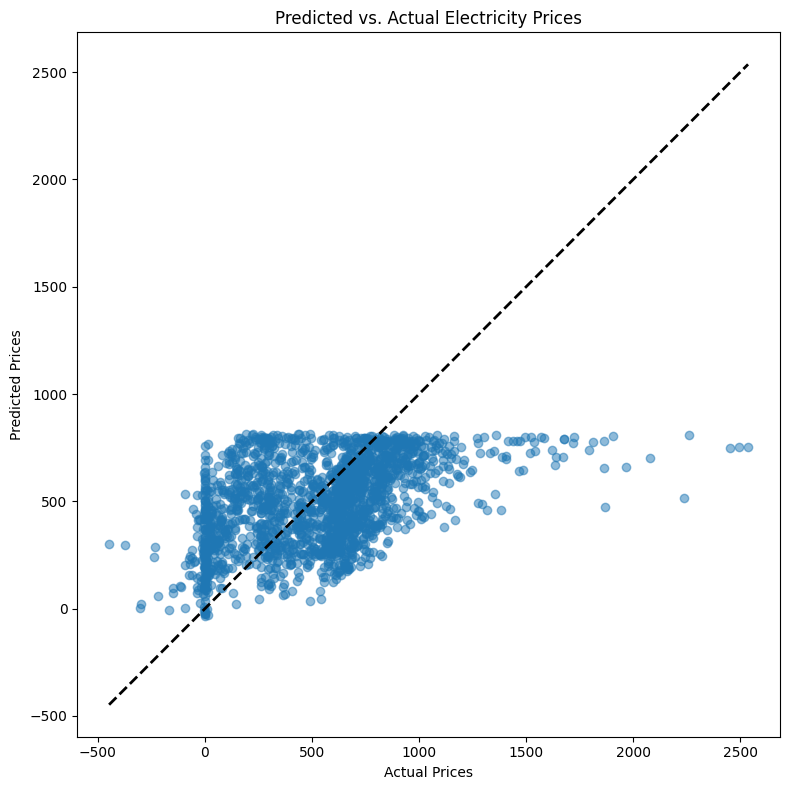

In [16]:
plt.figure(figsize=(8, 8))
plt.scatter(actuals, predictions, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs. Actual Electricity Prices')

# Plot a diagonal line for reference
min_price = min(actuals.min(), predictions.min())
max_price = max(actuals.max(), predictions.max())
plt.plot([min_price, max_price], [min_price, max_price], 'k--', lw=2)
plt.tight_layout()

plt.savefig('output/lstm_predicted_vs_actual_prices_scatter.png')
plt.show()